# Google trends analysis

Analysis of Google trends data for the term "causal inference".

Supporting notebook for the talk:

> What-if? Causal reasoning meets Bayesian Inference, presented at PyData Global 2022 by Benjamin T. Vincent 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import statsmodels.formula.api as smf

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# There was a change to data collection methods at this date.
change = pd.to_datetime("2022-01-01")

df = pd.read_csv("data/google_trends.csv", parse_dates=["week"])
df["time"] = df.index
df["step"] = df["week"] > change
df.set_index("week", inplace=True)
df

,causal_inference,time,step
week,,,
2017-12-03,48,0,False
2017-12-10,25,1,False
2017-12-17,15,2,False
2017-12-24,8,3,False
2017-12-31,21,4,False
...,...,...,...
2022-10-23,81,255,True
2022-10-30,89,256,True
2022-11-06,71,257,True


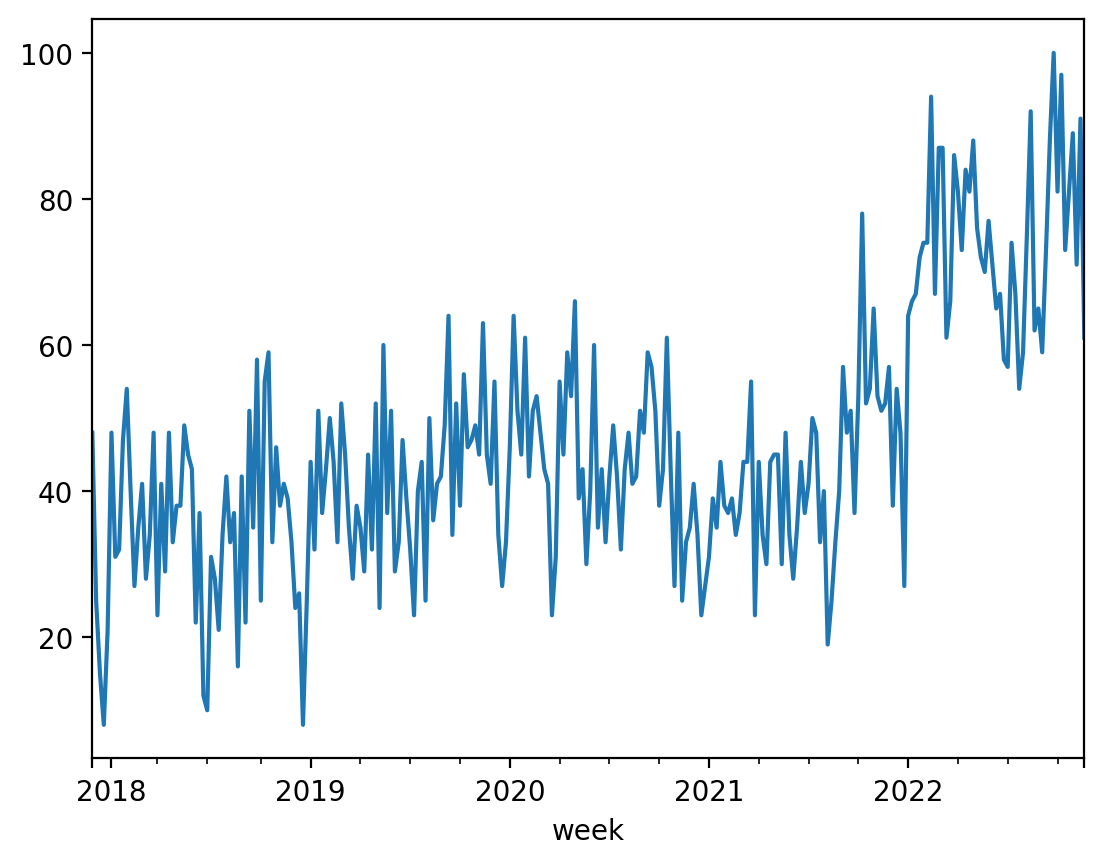

In [4]:
df["causal_inference"].plot();

## Frequentist analysis

In [5]:
results = smf.ols("causal_inference ~ time + step", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       causal_inference   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     183.4
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           3.28e-50
Time:                        17:02:52   Log-Likelihood:                -997.84
No. Observations:                 260   AIC:                             2002.
Df Residuals:                     257   BIC:                             2012.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       34.8896      1.537     22.702   

## Bayesian analysis

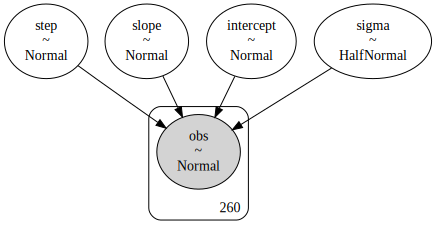

In [6]:
with pm.Model() as model:
    # priors
    intercept = pm.Normal("intercept", 20, 10)
    slope = pm.Normal("slope", 0, 10)
    step = pm.Normal("step", 50, 20)
    sigma = pm.HalfNormal("sigma", 20)
    # model
    mu = intercept + slope * df["time"].to_numpy() + step * df["step"].to_numpy()
    # likelihood
    pm.Normal("obs", mu, sigma, observed=df["causal_inference"].to_numpy())

pm.model_to_graphviz(model)

In [7]:
with model:
    idata = pm.sample()
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, step, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [obs]


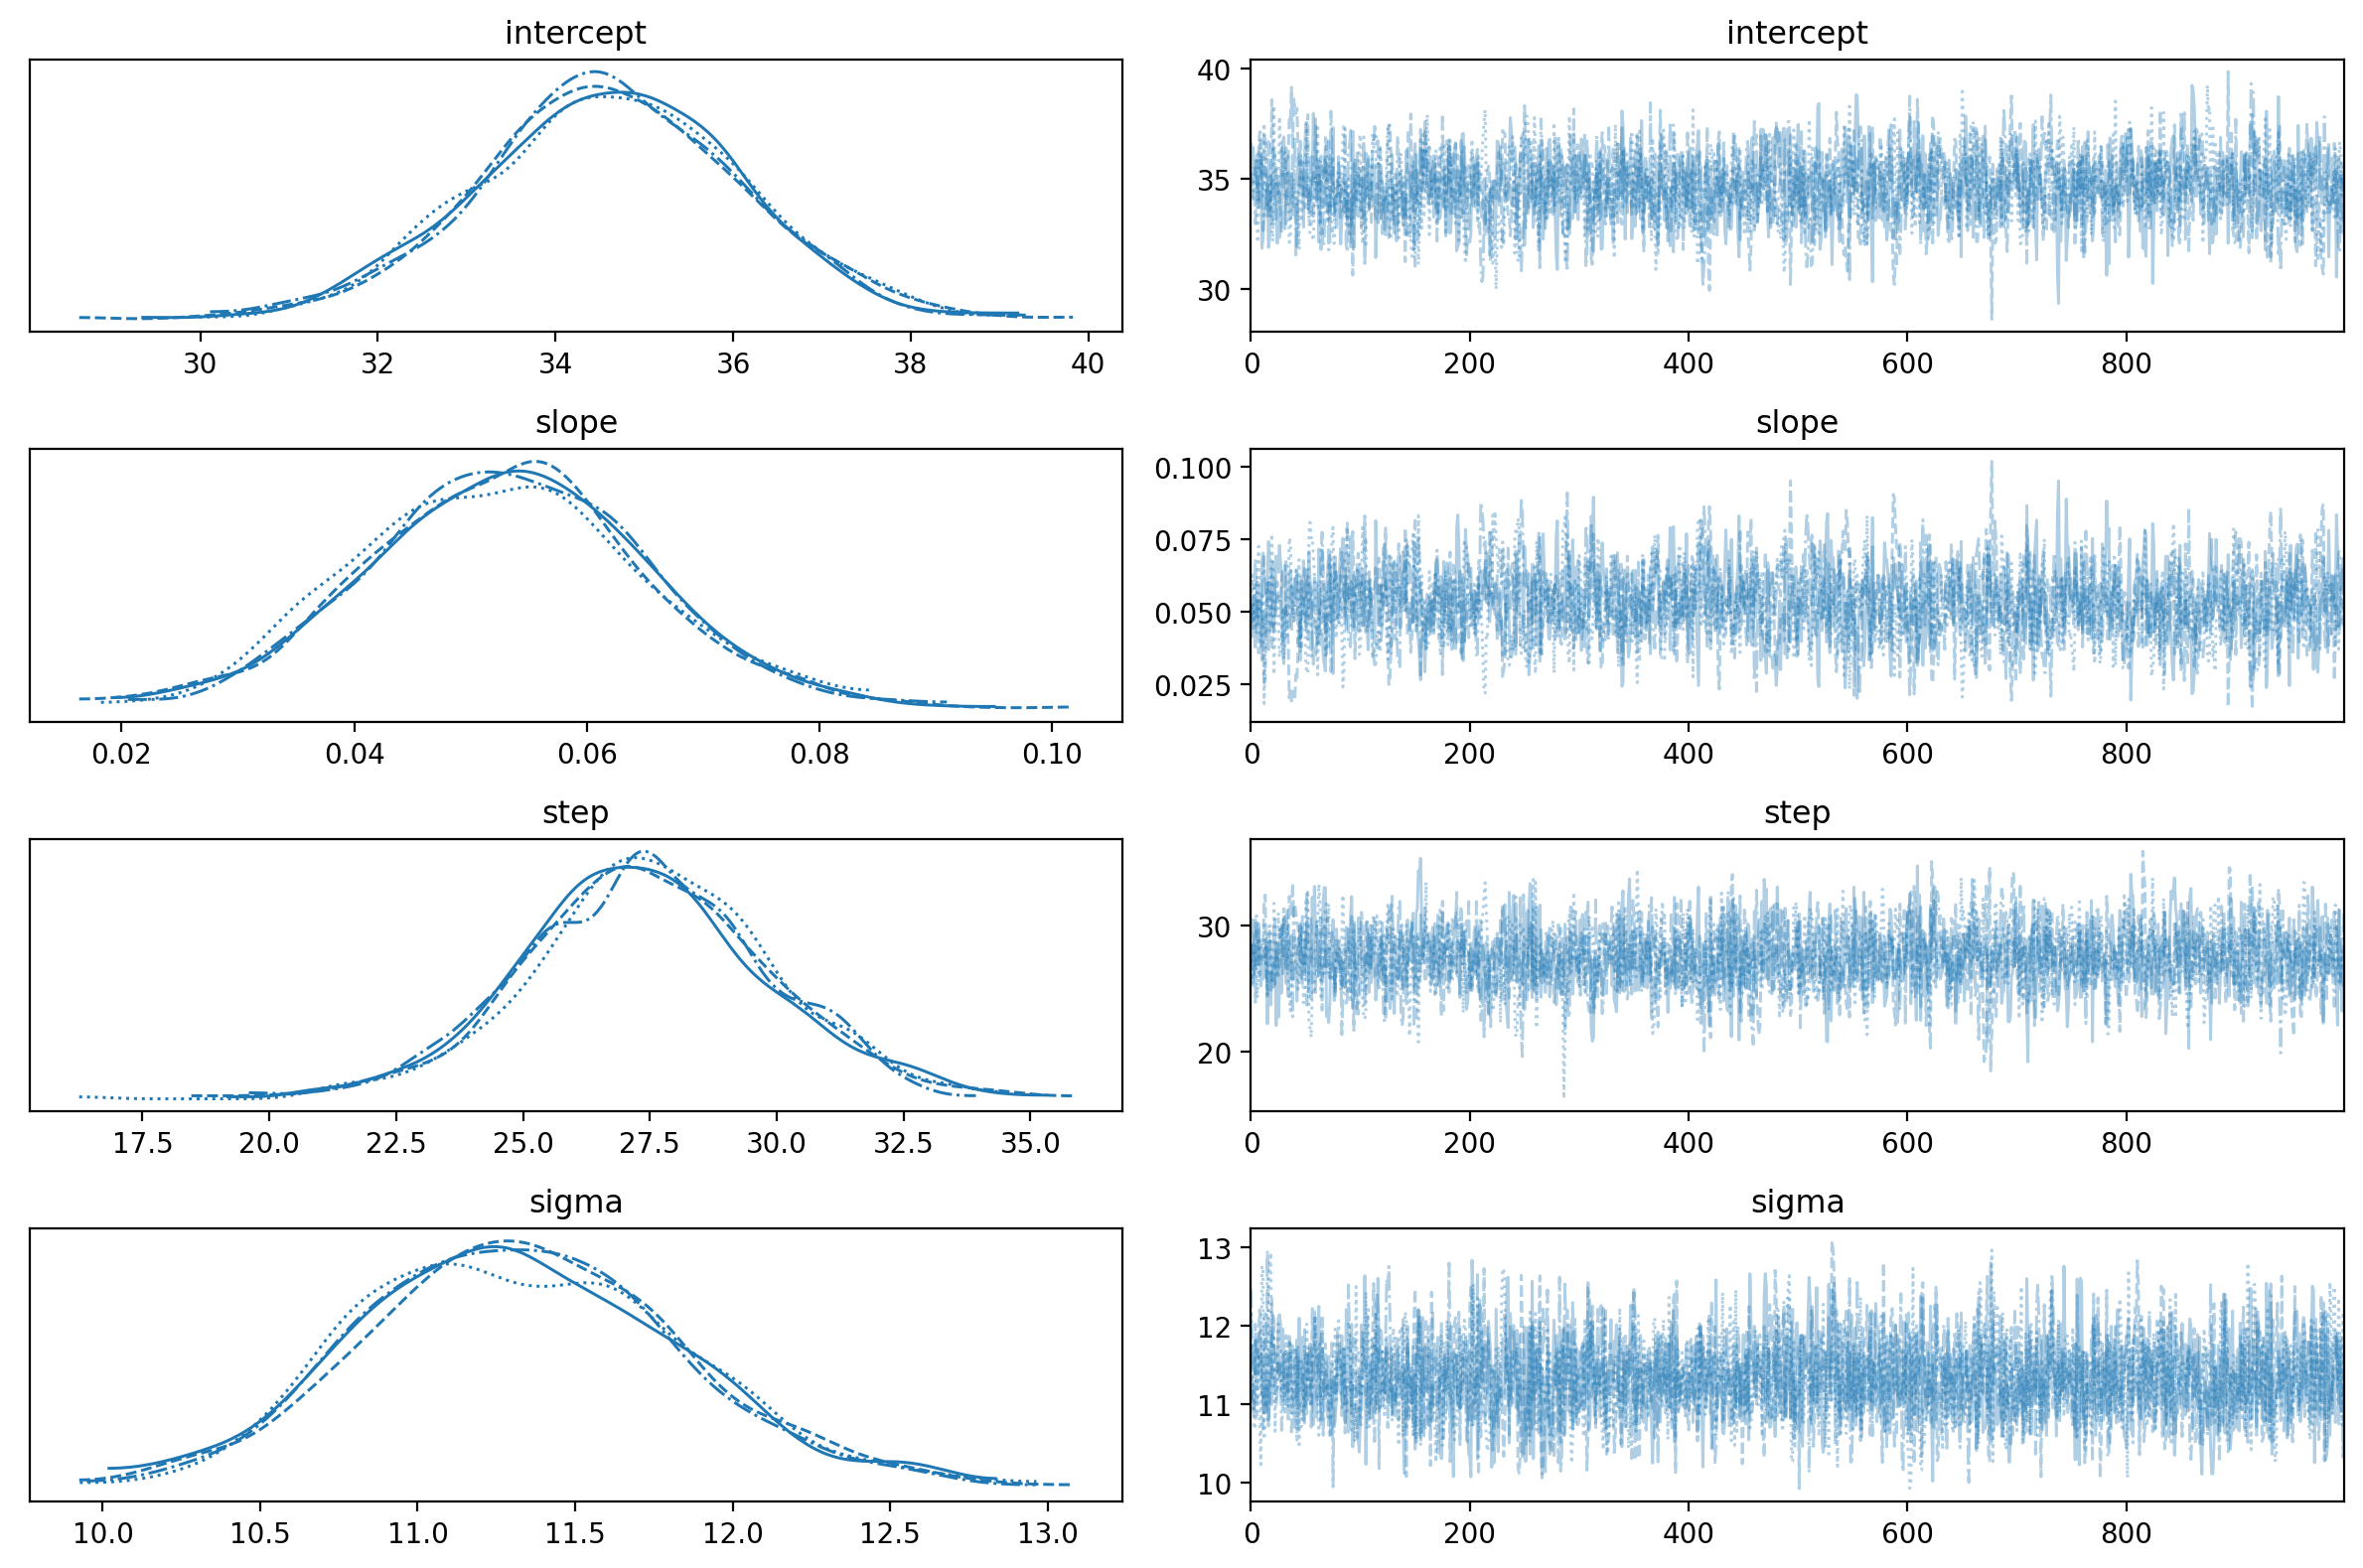

In [8]:
az.plot_trace(idata)
plt.tight_layout();

[Text(0.5, 1.0, 'inferred slope'), Text(0.5, 0, 'interest units per month')]

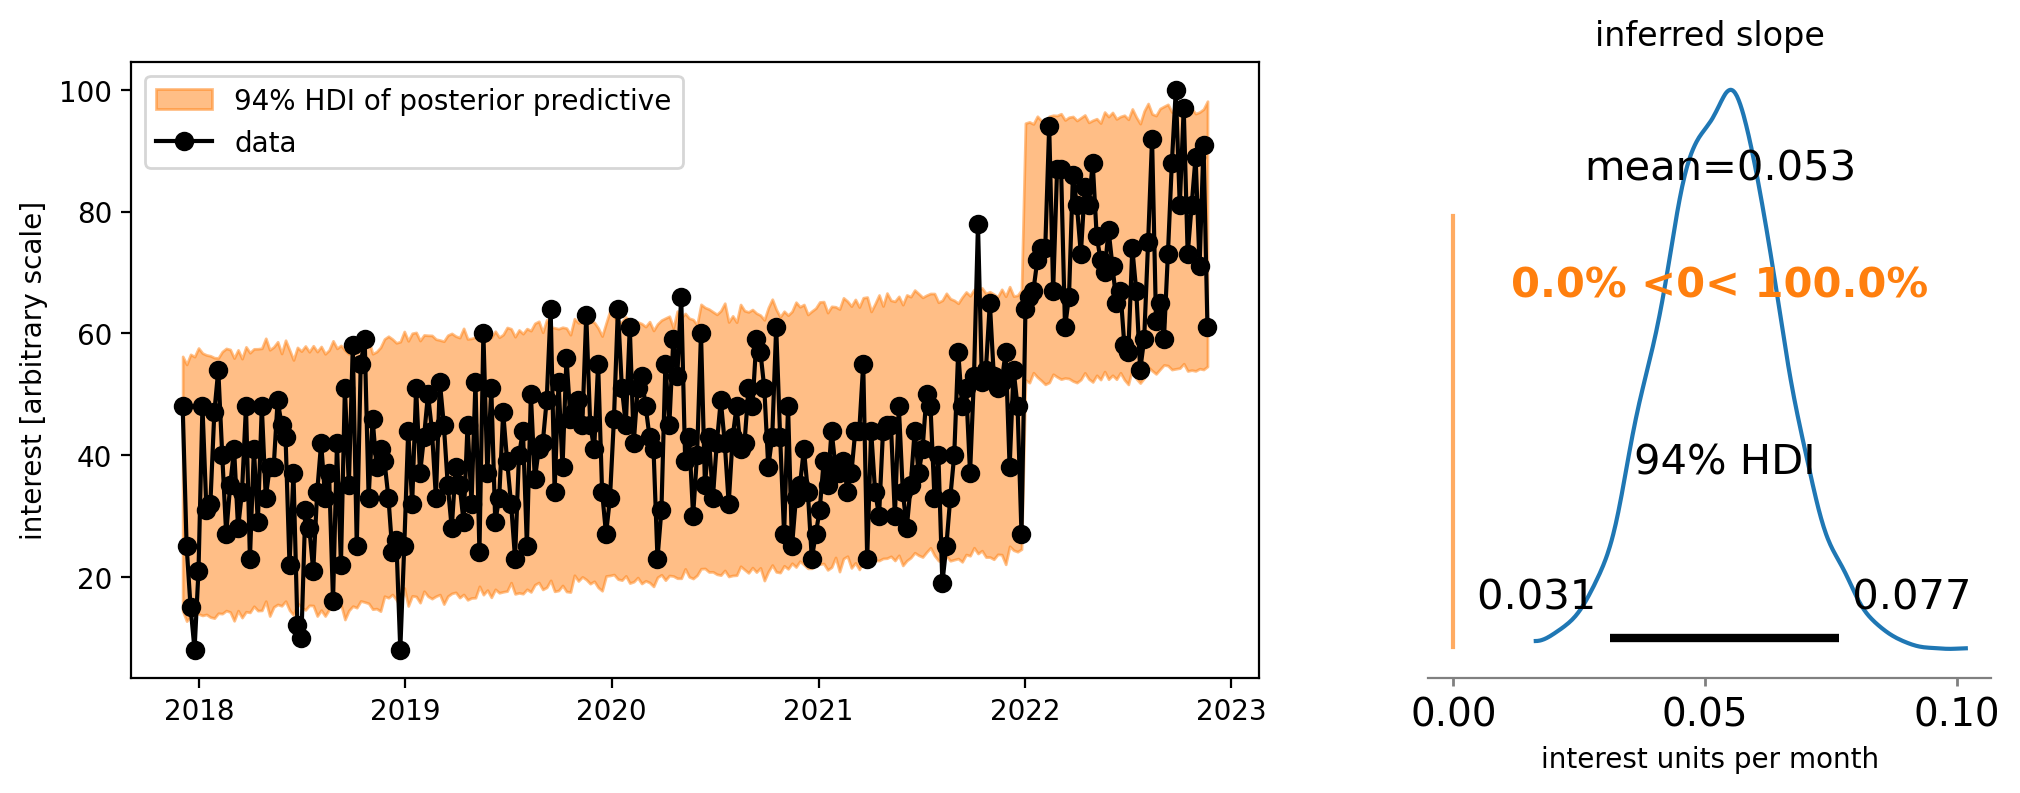

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})

az.plot_hdi(
    df.index,
    idata.posterior_predictive["obs"],
    smooth=False,
    ax=ax[0],
    fill_kwargs={
        "label": "94% HDI of posterior predictive",
    },
)
ax[0].plot(df.index, df["causal_inference"], "ko-", label="data")
ax[0].set(ylabel="interest [arbitrary scale]")
ax[0].legend()

az.plot_posterior(idata, var_names="slope", ref_val=0, ax=ax[1])
ax[1].set(title="inferred slope", xlabel="interest units per month")

# plt.savefig("img/google_trend_slope.png", bbox_inches="tight", dpi=300)

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,34.607,1.470,31.929,37.413,0.038,0.027,1504.0,2392.0,1.0
slope,0.053,0.012,0.031,0.077,0.000,0.000,1335.0,2038.0,1.0
step,27.432,2.402,22.948,32.073,0.053,0.038,2025.0,2527.0,1.0
sigma,11.327,0.508,10.362,12.272,0.009,0.007,3011.0,2713.0,1.0


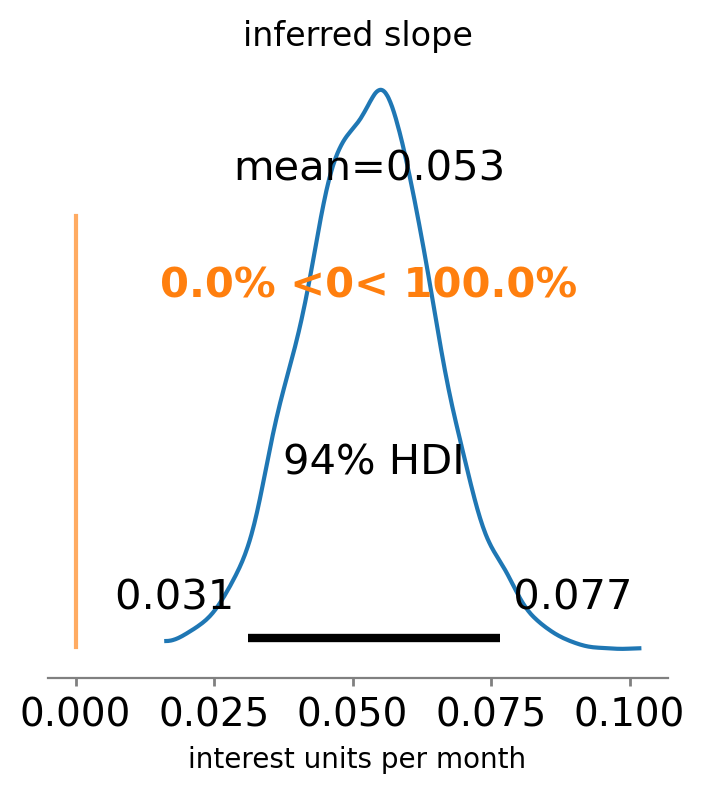

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))

ax = az.plot_posterior(idata, var_names="slope", ref_val=0, ax=ax)
ax.set(title="inferred slope", xlabel="interest units per month")

plt.savefig("img/google_trend_slope.png", bbox_inches="tight", dpi=300)